
## SGD set-up for a linear McKean-Vlasov SDE

Consider a McKean-Vlasov (MKV) SDE of the following form:

$$ 
\textrm{d}X_t = (\alpha \, X_t + \beta \, \mathbb{E}[X_t]) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad X_0 = x_0,
$$
for which we know $\mathbb{E}[X_t] = x_0\exp((\alpha+\beta)t).$

- Method 1:
    We approximate the solution $X_t, t \in [0,T]$ by using a piece-wise constant approximation for the function $\mathbb{E}[X_t]:$
    
    $$ 
    \textrm{d}Z_t = \bigl(\alpha \, Z_t + \beta \, \sum^M_{i=1} \widehat{\gamma}_{i-1} \mathbf{1}_{[t_{i-1},t_i[}(t) \bigr) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad Z_0 = x_0.
    $$
    
    We suppress the dependence of $Z$ on $\widehat{\gamma}$ in the notation. In the above, $t_i := T \frac{i}{M}, i = 0, 1, \ldots, M.$ The gradient process $\xi^i_t:= \partial_{\widehat{\gamma}_i}Z_t, i = 0, \ldots, M,$ is then given as 
    
    $$
    \textrm{d}\xi^i_t = \bigl(\alpha \, \xi^i_t + \beta \, \mathbf{1}_{[t_i,t_{i+1}[}(t) \bigr) \textrm{d} t, \quad \xi^i_0 = 0.
    $$

    In particular, we have 
    $$
    \xi^i_t = \begin{cases}
        0 & 0 \leq t \leq t_i \\ 
        \frac{\beta}{\alpha} (\exp(t-t_i) - 1) & t_i < t \leq t_{i+1} \\
        \frac{\beta}{\alpha} (\exp(t_{i+1}-t_i) - 1) & t_{i+1} < t \leq T
    \end{cases}.
    $$
    
    Our aim is to find the fixed-point of the map $\widehat{\Psi}^{(n)}$ defined as
    $$
      \widehat{\Psi}^{(n)}(\widehat{\gamma}):= \mathcal{P}\Bigl(\Psi\bigl(\mathcal{L}(\widehat{\gamma})\bigr)\Bigr).
    $$
    
    In the linear MKV-SDE considered here, we have $\Psi\bigl(\mathcal{L}(\widehat{\gamma})\bigr)(t) = \mathbb{E}[Z_t].$ We compute the fixed-point by solving the following: 
    $$
    \big| \widehat{\gamma} - \widehat{\Psi}^{(n)}(\widehat{\gamma})\big|^2.
    $$
    
    Using the notation from the Overleaf draft, we have
    
    $$
    F_i(\widehat{\gamma}, W) = Z_{t_i} - \widehat{\gamma}_i, \quad \text{and,} \quad \partial_{\widehat{\gamma}_j} F_i(\widehat{\gamma}, W) = \xi^j_{t_{i}} - \delta_{i}(j).
    $$

- Method 2:  
    We approximate the solution $X_t, t \in [0,T]$ by using a polynomial approximation for the function $\mathbb{E}[X_t]:$
    
    $$ 
    \textrm{d}Z_t = \bigl(\alpha \, Z_t + \beta \, \sum^{K-1}_{k=0} \widehat{\gamma}_k \prod_{\substack{ 1\leq j \leq K \\ k\neq j}} \frac{t-t_j}{t_k - t_j}  \bigr) \textrm{d} t + \sigma \, \textrm{d} W_t, \quad Z_0 = x_0.
    $$
    
    In the above, nodes $\{t_0, t_1, \ldots, t_K \},$ are chosen appropriately, either Chebychev or Lagrange nodes. The gradient process $\xi^k_t:= \partial_{\widehat{\gamma}_k}Z_t, k = 0, \ldots, K,$ is then given as 
    
    $$
    \textrm{d}\xi^k_t = \bigl(\alpha \, \xi^k_t + \beta \, \prod_{\substack{ 1\leq j \leq M \\ k\neq j}} \frac{t-t_j}{t_k - t_j} \bigr) \textrm{d} t, \quad \xi^k_0 = 0.
    $$

    We disretise the time interval $[0, T]$ uniformly into $M + 1$ steps, and insert Chebychev nodes to create a final time grid with $M+K$ intermediate points to generate discretised path of $Z$ and gradient processes. Our aim is to find the fixed-point of the map $\widehat{\Psi}^{(n)}$ defined as
    $$
      \widehat{\Psi}^{(n)}(\widehat{\gamma}):= \mathcal{P}\Bigl(\Psi\bigl(\mathcal{L}(\widehat{\gamma})\bigr)\Bigr).
    $$
    
    In the linear MKV-SDE considered here, we have $\Psi\bigl(\mathcal{L}(\widehat{\gamma})\bigr)(t) = \mathbb{E}[Z_t].$ We compute the fixed-point by solving the following: 
    $$
    \big| \widehat{\gamma} - \widehat{\Psi}^{(n)}(\widehat{\gamma})\big|^2.
    $$
    
    Using the notation from the Overleaf draft, we have
    
    $$
    F_i(\widehat{\gamma}, W) = Z_{t_i} - \widehat{\gamma}_i, \quad \text{and,} \quad \partial_{\widehat{\gamma}_j} F_i(\widehat{\gamma}, W) = \xi^j_{t_{i}} - \delta_{i}(j).
    $$

### Implementation for Method 1 (with tensors)

#### *Import relevant libraries*

In [16]:
import torch
import random
from torch import optim, nn
import math
import numpy
from numpy import pi
import matplotlib.pyplot as plt
from torchviz import make_dot

#### *Run on GPU if availbale*

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from res.plot_lib import plot_data, plot_model, set_default
set_default()

#### *Parameters*

In [18]:
M = 20  # number of discretisation steps
x0 = 10
sigma = 1
alpha = - 0.5
beta = 0.3
T = 0.1
dt = T / M
max_iter = 100000

tspace = torch.linspace(0, T, M)

gamma_benchmark = x0 * torch.exp((alpha + beta) * tspace)

#### *Define linear MKV SDE class*

In [19]:
class MKVSDElinear_approx(torch.nn.Module):
    def __init__(self, M):
        super().__init__()
        self.path = torch.zeros(M+1, requires_grad = False, dtype=torch.float, device=device)
    def generatepath(self, x0, gamma, alpha, beta, sigma, M, dt, dW): # Method 1
        self.path[0] = x0
        for i in range(M):
            self.path[i+1] = self.path[i] * (1 + alpha * dt) + beta * dt * gamma[i] + sigma * dW[i]

# seed initialise
torch.manual_seed(42)
# calculate deterministic gradient 
Z_grad = torch.zeros(M, M+1, requires_grad = False, dtype=torch.float, device=device)
for j in range(M):
    for i in range(M):
            Z_grad[j][i+1] = 0  if i < j else (beta / alpha) * (numpy.exp(dt) - 1)

#### SGD

In [20]:
lr = 0.01 # learning rate
l2pen = 0.0 # L2 penalty parameter
error_tol = 10e-6 # error tolerance
ctr = 0 # iteration counter
error = 1000 # error variable
gamma = x0 * torch.ones(M, requires_grad = False, dtype=torch.float, device=device)
Z = MKVSDElinear_approx(M)
gamma_aver = torch.zeros(M)

jacobian = torch.zeros(M, M)
for i in range(M):
    for j in range(M):
        jacobian[i][j] = Z_grad[j][i]
jacobian = jacobian - torch.eye(M)

while ctr < max_iter and error > error_tol:
    dW = dt ** 0.5 * torch.randn(M)
    Z.generatepath(x0, gamma, alpha, beta, sigma, M, dt, dW)
    loss_grad = 2 * (Z.path[0:M] - gamma)
    gamma_prev = gamma
    
    gamma = gamma_prev * (1 - l2pen) - lr * torch.matmul(loss_grad, jacobian)    
    gamma_aver += gamma

    if (ctr + 1) % 20000 == 0:
        print('Iteration: [{}/{}] '.format(ctr, max_iter))
#         lr = lr / 2
        
    ctr += 1

print(gamma_aver / max_iter)



Iteration: [19999/100000] 
Iteration: [39999/100000] 
Iteration: [59999/100000] 
Iteration: [79999/100000] 
Iteration: [99999/100000] 
tensor([10.0000,  9.9957,  9.9849,  9.9703,  9.9565,  9.9471,  9.9391,  9.9309,
         9.9212,  9.9103,  9.8996,  9.8895,  9.8802,  9.8710,  9.8610,  9.8509,
         9.8411,  9.8307,  9.8208,  9.8113])


Text(0.5, 1.0, 'N = 100000 M = 20')

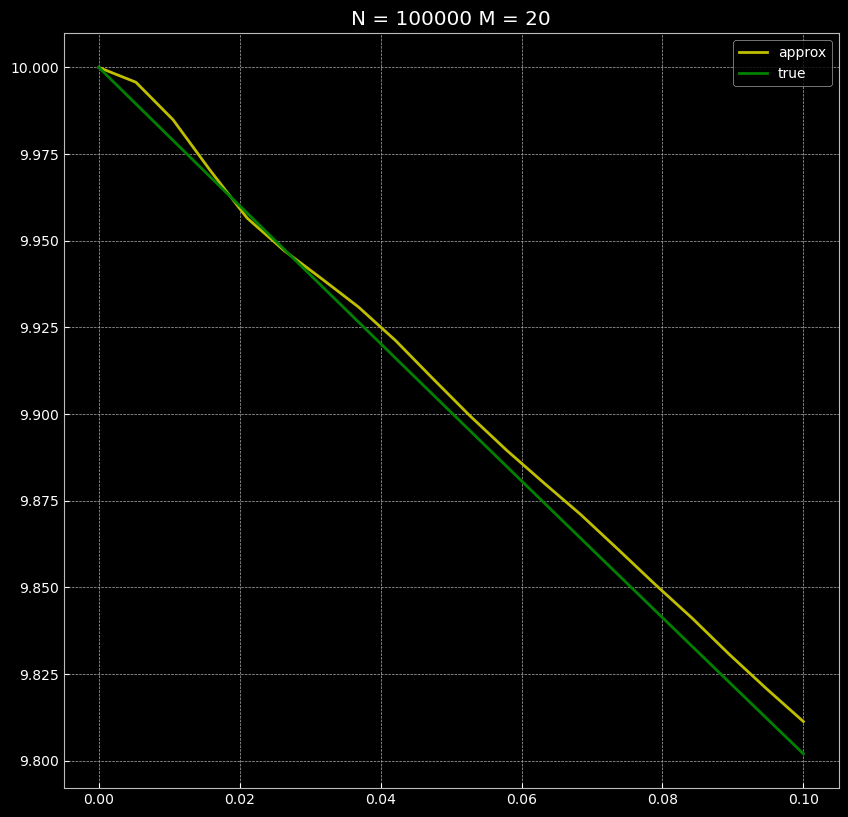

In [21]:
gamma_aver / max_iter
plt.plot(tspace, gamma_aver / max_iter, 'y', label='approx')
plt.plot(tspace, gamma_benchmark, 'g', label='true')
plt.legend()
plt.title('N = ' + str(max_iter) + ' M = ' + str(M))

In [ ]:
# gamma = torch.randn(M, requires_grad = False, dtype=torch.float, device=device)
# dW = dt ** 0.5 * torch.randn(M)
# Z.generatepath(x0, gamma, alpha, beta, sigma, M, dt, dW)
# tspace = torch.linspace(0, T, M + 1)
# plt.plot(tspace, Z.path.detach().numpy())
# plt.plot(tspace, Z_grad[4].detach().numpy())
# print(Z.path[0:M]-gamma)
# gamma = torch.randn(M, requires_grad = False, dtype=torch.float, device=device)
# gamma_prev = gamma
# print(gamma)
# print(gamma_prev)
# gamma = gamma_prev + 0.1
# print(gamma)
# print(gamma_prev)